# 주택가격예측
- 지도학습 : 레이블된 훈련 샘플이 있다.
- 회귀 : 값을 예측해야한다.
- 배치학습 : 데이터의 연속적인 흐름이 없고 빠르게 변화하는 데이터에 적응하지 않아도 된다.
- 성능 측정 지표 
    + 이상치가 드물때 : RMSE(평균 제곱근 오차)
    + 이상치가 많을때 : MAE(평균 절대 오차)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import tarfile
from six.moves import urllib

In [2]:
import os

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [3]:
def load_csv_data(path='./datasets'):
    csv_path = os.path.join(path,'train.csv')
    return pd.read_csv(csv_path,index_col='Id')

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
dataset = load_housing_data()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
dataset.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [7]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


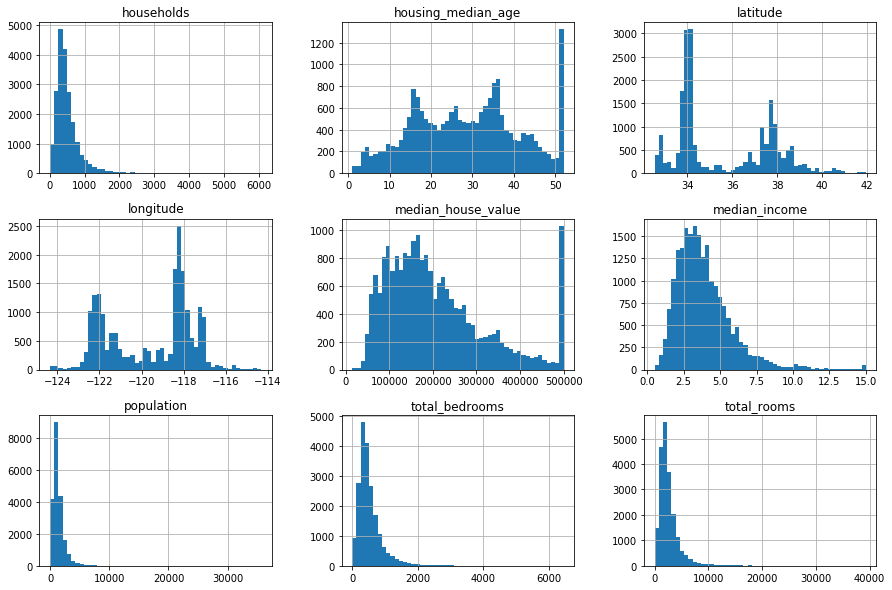

In [9]:
%matplotlib inline
dataset.hist(bins=50,figsize=(15,10))
plt.show()

## 테스트 데이터는 업데이트된 데이터셋을 사용해도 동일하게 유지하여야 한다.

- 훈련한 샘플을 포함하지 않아야한다.

In [23]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

dataset_with_id = dataset.reset_index()
train_set,test_set = split_train_test(dataset_with_id,0.2,"index")

In [24]:
import numpy as np
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [25]:
train_set,test_set = split_train_test(dataset,0.2)

print(train_set.shape)
print(test_set.shape)

(16512, 11)
(4128, 11)


In [26]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2,random_state=42)

## 테스트 데이터가 편향이 발생할 수 있기 때문에 `계층적 샘플링`이 필요하다.

- 균등해야 한다.(남 : 녀 = 50 : 50)
- `np.ceil` : 올림
- `where` : 조건에 대한 값 변경

계층적 샘플링을 위한 카테고리 구분짓기

In [27]:
dataset["income_cat"] = np.ceil(dataset["median_income"] / 1.5)
dataset["income_cat"].where(dataset["income_cat"] < 5,5.0,inplace=True)

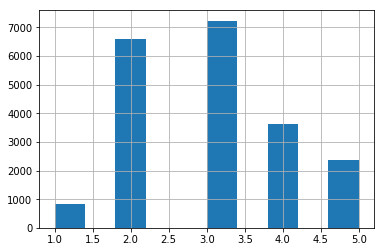

In [28]:
dataset["income_cat"].hist()

In [29]:
dataset["income_cat"].value_counts() / len(dataset)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [30]:
train_set, test_set = train_test_split(dataset, test_size=0.2,random_state=42)

In [31]:
train_set["income_cat"].value_counts() / len(train_set)

3.0    0.348595
2.0    0.317466
4.0    0.178537
5.0    0.115673
1.0    0.039729
Name: income_cat, dtype: float64

In [32]:
test_set["income_cat"].value_counts() / len(test_set)

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index,test_index in split.split(dataset,dataset["income_cat"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [34]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [35]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

## 계층적 샘플링

`StratifiedShuffleSplit` : 계층 샘플링 + 랜덤 샘플링

## 무작위 샘플링

`train_test_split`

In [36]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "전체": income_cat_proportions(dataset),
    "계층": income_cat_proportions(strat_test_set),
    "무작위": income_cat_proportions(test_set),
}).sort_index()
compare_props["무작위%error"] = 100 * compare_props["무작위"] / compare_props["전체"] - 100
compare_props["계층%error"] = 100 * compare_props["계층"] / compare_props["전체"] - 100

compare_props

,계층,무작위,전체,무작위%error,계층%error
1.0,0.039729,0.040213,0.039826,0.973236,-0.243309
2.0,0.318798,0.324370,0.318847,1.732260,-0.015195
3.0,0.350533,0.358527,0.350581,2.266446,-0.013820
4.0,0.176357,0.167393,0.176308,-5.056334,0.027480
5.0,0.114583,0.109496,0.114438,-4.318374,0.127011


In [37]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

## 데이터 시각화
- 손상시키지 않기 위해서 데이터를 복사

In [38]:
housing = strat_train_set.copy()

[Text(0, 0.5, 'latitude'), Text(0.5, 0, 'longitude')]

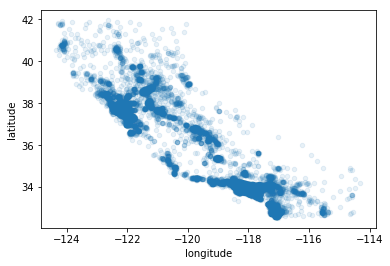

In [40]:
# 밀집지역이 잘 부각되었다.

ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
ax.set(xlabel='longitude', ylabel='latitude')

## 주택 가격을 나타내기
- s : 인구/원의 반지름
- c : 가격/색깔
- cmap : 가격의 범위/컬러맵

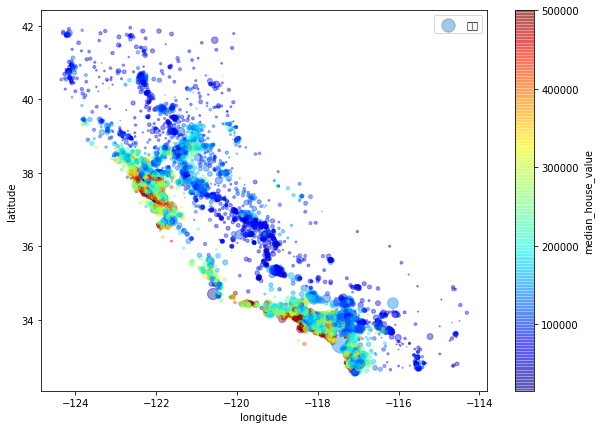

In [42]:
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="인구", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
ax.set(xlabel='longitude', ylabel='latitude')
plt.legend()

## 상관관계

1에 가까울수록 양의 상관관계
-1에 가까울수록 음의 상관관계

In [43]:
corr_matrix = housing.corr()

In [44]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002763C198898>,
      dtype=object)

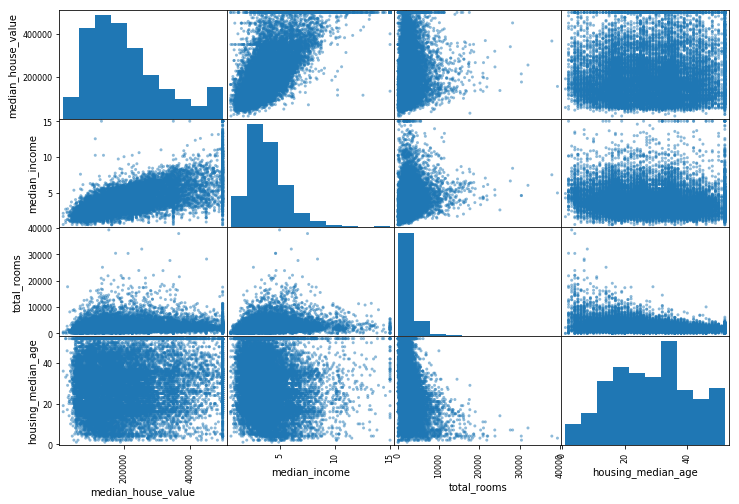

In [45]:
from pandas.plotting import scatter_matrix
# 산점도
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

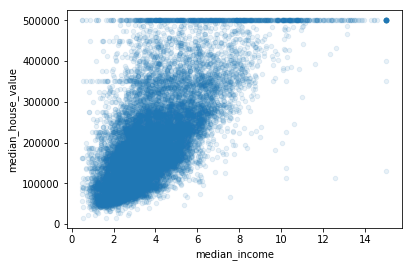

In [50]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [51]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_rooms"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [52]:
corr_matrix = housing.corr()

In [53]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rooms         -0.259984
Name: median_house_value, dtype: float64

# 데이터 준비
함수화 시켜야 한다.(자동화)

- 어떤 데이터셋에 대해서도 데이터 변환이 쉽다.
- 라이브러리 점진적 구축
- 조합이 어떤게 좋은지 확인하는데 편리하다.

In [54]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [55]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## 데이터 정제
- 특성없는 해당 구역을 제거한다.
- 전체 특성을 삭제한다.
- 어떤 값으로 채운다.(0,평균,중간값)

In [56]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # 누락된 값 다루기
housing_num = housing.drop("ocean_proximity",axis=1) # 텍스트 특성 제거
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [57]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [59]:
X = imputer.transform(housing_num)

In [60]:
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=list(housing.index.values))

In [61]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


In [62]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [63]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
print(housing_cat_encoded[:10])
print(housing_cat_encoded.shape)
print(housing_categories)

[0 0 1 2 0 2 0 2 0 0]
(16512,)
Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')


In [64]:
housing_cat_encoded.reshape(-1,1).shape

(16512, 1)

In [75]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))

print(housing_cat_1hot.toarray())
print(type(housing_cat_1hot))

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
<class 'scipy.sparse.csr.csr_matrix'>


In [73]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_onehot = encoder.fit_transform(housing_cat)

print(housing_cat_onehot)
print(type(housing_cat_onehot))

[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]]
<class 'numpy.ndarray'>


In [66]:
from sklearn.base import BaseEstimator, TransformerMixin

# 컬럼 인덱스
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs, 
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## 특성 스케일링
- min-max(정규화)
- 표준화

## 변환 파이프라인
- 많은 변환단계가 순서대로 실행되어야 한다.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")), # 누락된 값 추가
    ('attribs_adder',CombinedAttributesAdder()),  # 의미있는 속성 추가
    ('std_scaler',StandardScaler()),              # 표준화
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',SimpleImputer(strategy="median")), # 누락된 값 추가
    ('attribs_adder',CombinedAttributesAdder()),  # 의미있는 속성 추가
    ('std_scaler',StandardScaler()),              # 표준화
])

cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('cat_encoder',OneHotEncoder(categories='auto', sparse=False)),
])

In [ ]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num_pipeline", num_pipeline, num_attribs),
        ("cat_encoder", OneHotEncoder(categories='auto'), cat_attribs),
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("예측 : ",lin_reg.predict(some_data_prepared))
print("라벨 : ",list(some_labels))

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print("점수 : ",tree_rmse)

## 모델 세부 튜닝

In [ ]:
from sklearn.model_selection import cross_val_score
#교차검증
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준편차:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# 앙상블
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("점수 : ",forest_rmse)

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

## 그리드 탐색
- 하이퍼 파라미터 조합을 찾을 때 까지 수동으로 조정해준다.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor(n_estimators=10)

grid_search = GridSearchCV(forest_reg,
                           param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

## 랜덤 탐색

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                random_state=42, n_jobs=-1)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
rnd_search.best_params_

In [ ]:
rnd_search.best_estimator_

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
# cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_encoder = full_pipeline.named_transformers_["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

## 전처리 예측 파이프라인

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## 모델저장

In [ ]:
my_model = full_pipeline_with_predictor


from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## RandomizedSearchCV을 위한 Scipy 분포 함수

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# 1.질문
서포트 벡터 머신 회귀(sklearn.svm.SVR)를 kernel=“linear”(하이퍼파라미터 C를 바꿔가며)나 kernel=“rbf”(하이퍼파라미터 C와 gamma를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 SVR 모델은 무엇인가요?

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=1)
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=1, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
K = 5

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances,K)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:K]

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, K))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [ ]:
housing_prepared_top_k_features[0:3]

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, K)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("예측:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("레이블:\t\t", list(some_labels))

In [ ]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': list(range(1, len(feature_importances) + 1))}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=1)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

# PipeLine으로 순차적인 순서를 만들어서 실행하는 과정

## 전처리
- `DataFrameSelector()` : 데이터 선택
- `SimpleImputer()` : 누락된 값 추가
- `CombinedAttributesAdder()`  : 의미있는 속성 추가(직접 만든것)
- `StandardScaler()` : 표준화
- `OneHotEncoder()` : 인코딩

## 예측
- `LinearRegression()` : 선형회귀 예측
- `TopFeatureSelector()` : 중요한 특성 선택
- `SVR()` : 서포트 벡터 머신 예측
- `RandomForest()` : 랜덤 포레스트 예측(앙상블)
- `DecisionTreeRegressor()` : 결정 트리 예측